In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate

In [ ]:
from datasets import Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from evaluate import load
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import matplotlib.pyplot as plt

Preprocessed ve BERT dataseti, ikisi de özetlenmiş halde

In [ ]:
drive.mount('/content/drive')
root = "/content/drive/My Drive/Ara Dönem Proje Fake News Detection/Verisetleri"
#dataset name
file_name = "dataset_sum_bert.csv"
df = pd.read_csv(f"{root}/{file_name}")

Mounted at /content/drive


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df

In [ ]:
df.rename(columns = {'label':'class'}, inplace = True)

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
#Label Encoder 
label_to_id = {"True":1,"FAKE":0}
id_to_label = {0:"FAKE", 1:"True"}
num_labels = len(label_to_id)
label_to_id

{'True': 1, 'FAKE': 0}

In [ ]:
#Turkce dataset icin tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"], max_length = 128, padding = "max_length", truncation = True)
    return {"input_ids": tokenized.input_ids, "token_type_ids": tokenized.token_type_ids,
            "attention_mask": tokenized.attention_mask, "labels": [label_to_id[label] for label in examples["class"]]}

In [ ]:
#tokanizer olmus dataset
tokenized_datasets = dataset.map(tokenize_function, batched = True)
tokenized_datasets.set_format("torch")

  0%|          | 0/26 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

Dataset({
    features: ['text', 'class', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 25157
})

In [ ]:
dataloader = torch.utils.data.DataLoader(tokenized_datasets, batch_size = 32)

In [ ]:
for batch in dataloader:
  break
batch["labels"]

tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased").to("cuda")

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
X = []
y = []
with torch.no_grad():
  for batch in dataloader:
    X.append(model(batch["input_ids"].to("cuda"), batch["attention_mask"].to(device), batch["token_type_ids"].to(device)).pooler_output.cpu())
    y.extend(batch["labels"].tolist())

In [ ]:
X = torch.concatenate(X[:-1], axis = 0).tolist()

In [ ]:
y = y[:-5]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Text(0.5, 1.0, 'Dataset labels distribuition')

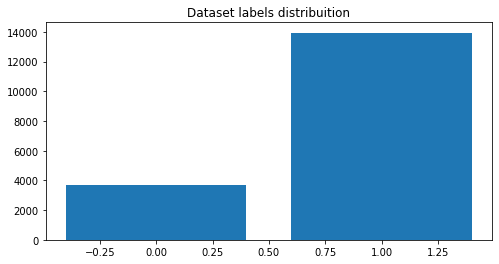

In [ ]:
target_cnt = Counter(y_train)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

SMOTE ADIMI

In [ ]:
from imblearn.over_sampling import SMOTE

def smote(x, y):
    smote = SMOTE(sampling_strategy= 1, random_state=42)
    x, y = smote.fit_resample(x, y)
    return x, y

In [ ]:
X_train, y_train = smote(X_train, y_train)

Text(0.5, 1.0, 'Dataset labels distribuition')

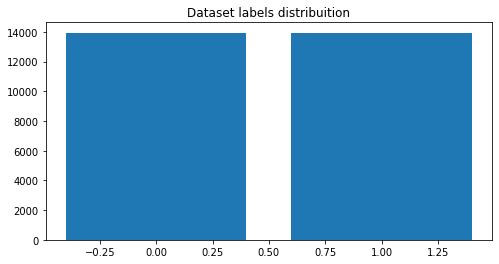

In [ ]:
target_cnt = Counter(y_train)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Classification Methods

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
def predict(sentence, classifier):
  inputs = tokenizer(sentence, max_length = 128, padding = "max_length", truncation = True, return_tensors = "pt")
  with torch.no_grad():
    X = model(inputs["input_ids"].to(device), inputs["attention_mask"].to(device), inputs["token_type_ids"].to(device)).pooler_output.cpu().tolist()
  
  return classifier.predict(X)

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1493
           1       0.99      0.97      0.98      6053

    accuracy                           0.97      7546
   macro avg       0.94      0.96      0.95      7546
weighted avg       0.97      0.97      0.97      7546



In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1493
           1       0.98      0.98      0.98      6053

    accuracy                           0.97      7546
   macro avg       0.94      0.95      0.95      7546
weighted avg       0.97      0.97      0.97      7546



In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.99      0.73      1493
           1       1.00      0.83      0.90      6053

    accuracy                           0.86      7546
   macro avg       0.79      0.91      0.82      7546
weighted avg       0.91      0.86      0.87      7546



In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.62      0.52      1493
           1       0.90      0.81      0.85      6053

    accuracy                           0.77      7546
   macro avg       0.67      0.71      0.68      7546
weighted avg       0.81      0.77      0.78      7546



In [ ]:
predict("Lozan'ın Bitişiyle Boş Arazilere Akın Eden Vatandaşların ''Petrolü Kim Çıkaracak?'' Kavgasında Kazma ve Kürekler Konuştu: 116 Yaralı...", lr)

array([0])

In [1]:
predict("Tarım ve Orman Bakanlığının, Twitter hesabından yapılan paylaşıma göre, DSİ’nin merkez ve taşra teşkilatında, 657 sayılı Devlet Memurları Kanunu’nun 4/B maddesi kapsamında istihdam edilmek üzere, çeşitli branşlarda toplam 1273 sözleşmeli personel alımı yapılacak.", nb)

NameError: ignored